<a href="https://colab.research.google.com/github/iffyaiyan/cohere_rag/blob/master/Data_Ingestion_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Data Ingestion and Preprocessing**

At its core, RAG (Retrieval-Augmented Generation) is a method for integrating private data with pre-trained, instruction-tuned language models. The effectiveness of our RAG system is directly proportional to the quality of our data ingestion pipeline.

Data ingestion encompasses both data sources and preprocessing. As with most machine learning systems, the principle of "garbage in, garbage out" applies to LLMs. Therefore, optimizing our data ingestion pipeline is crucial for RAG efficacy.

Key considerations for efficient data ingestion:

1.  **Periodic updates:** Implement a system that can seamlessly update when data sources change.
2. **Quality control:** Ensure data cleanliness and relevance.
3. **Scalability:** Design the pipeline to handle increasing data volumes.

**Tip:** When building a data ingestion pipeline, start with a small, representative sample of data. This allows us to quickly iterate on our preprocessing steps and catch potential issues early. Focus on creating an end-to-end working system before optimizing specific components like chunk size, parsing strategies, or data formats (e.g., markdown, HTML, plain text).


In [1]:
!git clone https://github.com/wandb/edu.git
%cd edu/rag-advanced
!pip install -qqq -r requirements.txt
%cd notebooks

import nltk

nltk.download("wordnet")
nltk.download("punkt")

Cloning into 'edu'...
remote: Enumerating objects: 4762, done.
remote: Counting objects: 100% (1645/1645), done.
remote: Compressing objects: 100% (723/723), done.
remote: Total 4762 (delta 1182), reused 1192 (delta 910), pack-reused 3117 (from 1)
Receiving objects: 100% (4762/4762), 41.95 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (2596/2596), done.
/content/edu/rag-advanced
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 22.0 MB/s eta 0:0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import os
import wandb

# Store your API key securely in Colab’s secret environment
os.environ['COHERE_API_KEY'] = "COHERE_API_KEY"
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import asyncio

import nest_asyncio

nest_asyncio.apply()
import numpy as np
import weave

from scripts.utils import display_source

In [4]:
WANDB_PROJECT = "rag-course-data-ingestion-processing"

weave_client = weave.init(WANDB_PROJECT)

Logged in as Weights & Biases user: iffyaiyan06.
View Weave data at https://wandb.ai/iffyaiyan06-lawminds/rag-course-data-ingestion-processing/weave


### **Data Preparation**

Let's begin our journey with raw data processing.

 First step is to retrieve the most recent `raw_data` we logged into weave.

In [5]:
# download the `raw_data` Dataset
raw_data = weave.ref(
    "weave:///rag-course/rag-course/object/raw_data:nuZosGsP58MXKxhluN2hzvKK9XB8xSxlTuOBmEzWzLo"
).get()
# uncomment the next line to get the raw data from weave from your own project instead
# raw_data = weave.ref("raw_data:v0").get()

# this is how we index into the data
print(raw_data.rows[:2])
raw_data = list(map(dict, raw_data.rows[:]))

[WeaveDict({'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key f

Earlier I naively counted each word (as they appear in English text) as one token (`raw_tokens`). Now let's update to using the correct token counting strategy (`tokens`).

I will use `Cohere's tokenizer` to calculate the accurate number of tokens per document in our raw_data. Both the correct token count and word count will be stored as metadata for each document.

In RAG systems, accurate tokenization is crucial for proper text processing and context management. Let's examine two key functions: `tokenize_text` and `length_function`.

The **`tokenize_text`** **Function**: This function tokenizes input text using Cohere's tokenization API. Here's how it works:

1. It initializes a Cohere client using an API key stored in environment variables.
2. It calls the `tokenize` method of the Cohere client, passing:
  * The input text
  * The specified `model` (defaulting to "command-r")
  * `offline=True` to use a locally cached tokenizer for efficiency

The function returns a list of tokens, which are subword units that the model uses to process text.

The **`length_function`**: This function calculates the number of tokens in a given text. It operates as follows:

1. It calls `tokenize_text` to convert the input `text` into `tokens`.
2. It returns the length of the resulting token list.

Understanding the token count is essential because:

* It helps determine if a text fits within a model's context window.
* It allows for more accurate text chunking and processing in the RAG pipeline.
* It provides a basis for estimating computational costs, as many API pricing models are based on token count.

By using these functions, we ensure consistent and accurate tokenization throughout our RAG system, which is critical for retrieval accuracy and overall performance.

In [6]:
from scripts.utils import (
    TOKENIZERS,
    get_special_tokens_set,
    length_function,
    tokenize_text,
)

# this is the function that will tokenize the text
display_source(tokenize_text)
# this is the function that calculates the number of tokens
display_source(length_function)

   1 def tokenize_text(text: str, model: str = "command-r") -> List[str]:                                          
   2     """                                                                                                       
   3     Tokenizes the given text using the specified model.                                                       
   4                                                                                                               
   5     Args:                                                                                                     
   6         text (str): The text to be tokenized.                                                                 
   7         model (str): The model to use for tokenization. Defaults to "command-r".                              
   8                                                                                                               
   9     Returns:                                                                                                  
  10         List[str]: A list of tokens.                                                                          
  11     """                                                                                                       
  12     co = cohere.Client(api_key=os.environ["COHERE_API_KEY"])                                                  
  13     return co.tokenize(text=text, model=model, offline=True)                                                  
  14                                                                                                               

   1 def length_function(text, model="command-r"):                                                                 
   2     """                                                                                                       
   3     Calculate the length of the tokenized text using the specified model.                                     
   4                                                                                                               
   5     Args:                                                                                                     
   6         text (str): The text to be tokenized and measured.                                                    
   7         model (str): The model to use for tokenization. Defaults to "command-r".                              
   8                                                                                                               
   9     Returns:                                                                                                  
  10         int: The number of tokens in the tokenized text.                                                      
  11     """                                                                                                       
  12     return len(tokenize_text(text, model=model).tokens)                                                       
  13                                                                                                               

In [7]:
for doc in raw_data[:]:
    doc["metadata"]["words"] = doc["metadata"].pop("raw_tokens")
    doc["metadata"]["tokens"] = length_function(doc["content"])
raw_data[:2]


[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

Knowing the correct number of tokens is crucial for several reasons:

1. It helps decide whether to build a RAG pipeline or ingest the whole document into an LLM, especially now that many top LLMs support long context windows.
2. It informs the optimal chunk size for efficient processing.
3. It ensures efficient use of context windows and helps manage costs associated with token-based API calls.
4. It aids in predicting and controlling response generation length, which is vital for maintaining coherent and relevant outputs.

By accurately counting tokens, we can make informed decisions about our RAG system's architecture and optimize its performance and cost-effectiveness.

**Tip:** Different tokenizers may produce slightly different results. Always use the same tokenizer that your target LLM uses to ensure consistency between preprocessing and model input.



### **Preprocessing**


Now that I have my raw data prepared and correctly tokenized, the next crucial step is to pre-process this data. `Preprocessing` is essential for removing extraneous information and formatting that could interfere with my language model's understanding of the content.

In this section, I'll focus on cleaning my data by removing markdown elements, special characters, and extra whitespace. This process will help streamline my text for more effective tokenization and ultimately improve the performance of my RAG system.

Raw data often contains extra formatting information (like markdown elements) that, while useful for human readers, is not beneficial for LLMs. Removing these elements, along with special characters and extra whitespace, is essential in RAG preprocessing for several reasons:

1. It eliminates noise and irrelevant information that could confuse the LLM.
2. It ensures the model focuses solely on the content's semantic meaning.
3. It standardizes input across various document types, creating a consistent format for the LLM.
4. It can improve retrieval accuracy and response generation quality.

To achieve this, we use two key functions:

1. `convert_contents_to_text`: This function converts raw markdown to HTML, then uses BeautifulSoup to remove image links, images, and other formatting information.
2. `make_text_tokenization_safe`: This function removes any special tokens present in the text. Special characters here are those defined in the tokenizer and may vary depending on the model used.

By applying these preprocessing steps, we create clean, standardized input that's optimized for our LLM pipeline.

**Best Practice:** When cleaning text data, be cautious about removing too much information. While it's important to remove noise, overzealous cleaning might inadvertently remove context that could be valuable for the LLM.

In [8]:
from scripts.preprocess import convert_contents_to_text, make_text_tokenization_safe

# this is the function that converts the markdown to html
display_source(convert_contents_to_text)
# this is the function that cleans the text
display_source(make_text_tokenization_safe)

   1 def convert_contents_to_text(contents: str) -> str:                                                           
   2     """                                                                                                       
   3     Converts the given markdown content to plain text.                                                        
   4                                                                                                               
   5     Args:                                                                                                     
   6         contents: A string containing the markdown content.                                                   
   7                                                                                                               
   8     Returns:                                                                                                  
   9         A string containing the plain text extracted from the markdown content.                               
  10     """                                                                                                       
  11     _, content = frontmatter.parse(contents)                                                                  
  12     markdown_document = markdown.markdown(                                                                    
  13         content,                                                                                              
  14         extensions=[                                                                                          
  15             "toc",                                                                                            
  16             "pymdownx.extra",                                                                                 
  17             "pymdownx.blocks.admonition",                                                                     
  18             "pymdownx.magiclink",                                                                             
  19             "pymdownx.blocks.tab",                                                                            
  20             "pymdownx.pathconverter",                                                                         
  21             "pymdownx.saneheaders",                                                                           
  22             "pymdownx.striphtml",                                                                             
  23             "pymdownx.highlight",                                                                             
  24             "pymdownx.pathconverter",                                                                         
  25             "pymdownx.escapeall",                                                                             
  26         ],                                                                                                    
  27     )                                                                                                         
  28     soup = BeautifulSoup(markdown_document, "html.parser")                                                    
  29                                                                                                               
  30     def remove_urls_a_tags_hrefs(soup):                                                                       
  31         """                                                                                                   
  32         Removes URLs, <a> tags, and <img> tags from the BeautifulSoup object.                                 
  33                                                                                                               
  34         Args:                                                                                                 
  35             soup: A BeautifulSoup object containing

   1 def make_text_tokenization_safe(                                                                              
   2     content: str, special_tokens_set: set = get_special_tokens_set()                                          
   3 ) -> str:                                                                                                     
   4     """                                                                                                       
   5     Makes the text safe for tokenization by removing special tokens.                                          
   6                                                                                                               
   7     Args:                                                                                                     
   8         content: A string containing the text to be processed.                                                
   9         special_tokens_set: A set of special tokens to be removed from the text.                              
  10                                                                                                               
  11     Returns:                                                                                                  
  12         A string with the special tokens removed.                                                             
  13     """                                                                                                       
  14                                                                                                               
  15     def remove_special_tokens(text: str) -> str:                                                              
  16         """                                                                                                   
  17         Removes special tokens from the given text.                                                           
  18                                                                                                               
  19         Args:                                                                                                 
  20             text: A string representing the text.                                                             
  21                                                                                                               
  22         Returns:                                                                                              
  23             The text with special tokens removed.                                                             
  24         """                                                                                                   
  25         for token in special_tokens_set:                                                                      
  26             text = text.replace(token, "")                                                                    
  27         return text                                                                                           
  28                                                                                                               
  29     cleaned_content = remove_special_tokens(content)                                                          
  30     return cleaned_content                                                                                    
  31                                                                                                               

I am converting the raw markdown documents to text and making them tokenization-safe. This process involves removing special tokens that could interfere with the tokenization process. Let's examine the first 5 special tokens to understand what's being removed.

After processing, you'll notice that the **`parsed_tokens`** count is smaller compared to the original **`tokens`** count. This reduction is expected and indicates that we've successfully removed extraneous formatting and special characters, resulting in a cleaner text representation that's more suitable for our LLM pipeline.

This step is crucial for ensuring that our input data is optimized for tokenization and subsequent processing by the language model.

In [9]:
special_tokens_set = get_special_tokens_set(TOKENIZERS["command-r"])
print(list(special_tokens_set)[:5])

parsed_data = []

for doc in raw_data:
    parsed_doc = doc.copy()
    content = convert_contents_to_text(doc["content"])
    parsed_doc["parsed_content"] = make_text_tokenization_safe(
        content, special_tokens_set=special_tokens_set
    )
    parsed_doc["metadata"]["parsed_tokens"] = length_function(
        parsed_doc["parsed_content"]
    )
    parsed_data.append(parsed_doc)
parsed_data[:2]

['<|EXTRA_9_TOKEN|>', '<|USER_2_TOKEN|>', '<|EXTRA_2_TOKEN|>', '<|USER_3_TOKEN|>', '<EOP_TOKEN>']


[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

Let's store the parsed data as a Weave dataset

In [10]:
# build weave dataset
parsed_data = weave.Dataset(name="parsed_data", rows=parsed_data)

# publish the dataset
weave.publish(parsed_data)


📦 Published to https://wandb.ai/iffyaiyan06-lawminds/rag-course-data-ingestion-processing/weave/objects/parsed_data/versions/QlivWIvSpYwtTjyVWgv7urlA4TxjUUqEKOuAW4e5Nas


ObjectRef(entity='iffyaiyan06-lawminds', project='rag-course-data-ingestion-processing', name='parsed_data', _digest='QlivWIvSpYwtTjyVWgv7urlA4TxjUUqEKOuAW4e5Nas', _extra=())

### **Data Chunking**


With data cleaned and pre-processed, let's move on to the next critical step: **chunking**. `Chunking` involves breaking down our processed documents into smaller, manageable pieces. This step is crucial for several reasons:

1. It allows us to retrieve more relevant information
2. It helps manage token limits in language models
3. It can improve the overall efficiency of our RAG system

In this section, I'll explore different chunking strategies and implement a `semantic chunking` approach, which aims to preserve the context and meaning of our text while splitting it into appropriate segments.

We can split the processed data into smaller chunks. This approach serves two purposes:

1. Reduce input token cost by sending only the required data for generation.
2. Limit context to ensure the LLM focuses on relevant details.

While sending the entire document to the LLM is possible, it depends on the total token count and the nature of our use case. This approach can be costlier but is a good starting point.

**Semantic Chunking**

Various chunking strategies exist, such as splitting after n words/tokens or on headers. It's advisable to experiment with these simple strategies before moving to more sophisticated ones.

Below, I implement `semantic chunking`, a sophisticated strategy that has proven effective in practice. This method groups similar sentences into chunks:

1. Split the text into sentences using the BlingFire library.
2. Group and combine chunks based on semantic similarity.

Semantic chunking offers key advantages over simpler methods like fixed-length splitting:

1. **Improved Relevance:** Groups related sentences, increasing the likelihood of retrieving complete, relevant information.
2. **Context Preservation:** Maintains logical flow within chunks, crucial for accurate LLM understanding and generation.
3. **Adaptive Segmentation:** Creates variable-length chunks that better represent the text's natural structure and content organization.

By keeping related information together, semantic chunking optimizes retrieval accuracy and enhances the RAG system's ability to provide contextually appropriate responses.

In [11]:
# download the `parsed_data` Dataset
parsed_data = weave.ref(
    "weave:///rag-course/rag-course/object/parsed_data:UhWHAwXzvIcYaZ3X1x4eX2KDyYhCM4TPSsj8Oq8dLq4"
).get()
# uncomment the next line to get the parsed data from weave from your own project instead
# parsed_data = weave.ref("parsed_data:v0").get()

# this is how we index into the data
print(parsed_data.rows[:2])

parsed_data = list(map(dict, parsed_data.rows[:]))
parsed_data[:2]

[WeaveDict({'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key f

[{'content': '---\ndescription: Log and visualize data without a W&B account\ndisplayed_sidebar: default\n---\n\n# Anonymous Mode\n\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first.\n\nAllow results to be logged in Anonymous Mode with `wandb.init(`**`anonymous="allow"`**`)`\n\n:::info\n**Publishing a paper?** Please [cite W&B](https://docs.wandb.ai/company/academics#bibtex-citation), and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\n\n### How does someone without an account see results?\n\nIf someone runs your script and you have to set `anonymous="allow"`:\n\n1. **Auto-create temporary account:** W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the ses

In [12]:
from scripts.chunking import chunk_documents

# this is the function that chunks the documents
display_source(chunk_documents)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   1 def chunk_documents(docs, chunk_size=CHUNK_SIZE):                                                             
   2     """                                                                                                       
   3     Chunks a list of documents into smaller pieces based on the specified chunk size.                         
   4                                                                                                               
   5     Args:                                                                                                     
   6         docs (list): A list of documents to be chunked. Each document should contain 'parsed_content' and 'met
   7         chunk_size (int): The desired size of each chunk. Defaults to CHUNK_SIZE.                             
   8                                                                                                               
   9     Returns:                                                                                                  
  10         list: A list of dictionaries, each containing 'cleaned_content' and 'metadata' for each chunk.        
  11     """                                                                                                       
  12     chuker = partial(chunk_document, chunk_size=chunk_size)                                                   
  13     chunked_data = map(chuker, docs)                                                                          
  14     chunked_docs = [                                                                                          
  15         item for sublist in tqdm(chunked_data, total=len(docs)) for item in sublist                           
  16     ]                                                                                                         
  17     return chunked_docs                                                                                       
  18                                                                                                               

Since I am doing semantic chunking, the chunking process can take a while. For now, let's just take the first 5 documents and chunk them.

In [13]:
sample_chunked_data = chunk_documents(parsed_data[:5])
sample_chunked_data[:2]

  0%|          | 0/5 [00:00<?, ?it/s]

[{'cleaned_content': 'Anonymous Mode\nAre you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first. Allow results to be logged in Anonymous Mode with wandb.init(anonymous="allow")\n:::info\nPublishing a paper? Please cite W&B, and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n:::\nHow does someone without an account see results? If someone runs your script and you have to set anonymous="allow":\n\nAuto-create temporary account: W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the session. Log results quickly: The user can run and re-run the script, and automatically see results show up in the W&B dashboard UI.\nThese unclaimed anonymous runs will be available for 7 days.

In [14]:
# fetch the chunked data
chunked_data = weave.ref(
    "weave:///rag-course/rag-course/object/chunked_data:Ij9KThmiZQ9ljpCm8rVXTJlCaAbY2qC0zX6UJkBWHQ0"
).get()
# uncomment the next line to get the chunked data from weave from your own project instead
# chunked_data = weave.ref("chunked_data:latest").get()

# this is how we index into the data
print(chunked_data.rows[:2])

chunked_data = list(map(dict, chunked_data.rows[:]))

[WeaveDict({'cleaned_content': 'Anonymous Mode Are you publishing code that you want anyone to be able to run easily? Use Anonymous Mode to let someone run your code, see a W&B dashboard, and visualize results without needing to create a W&B account first. Allow results to be logged in Anonymous Mode with wandb.init(anonymous="allow") :::info Publishing a paper? Please cite W&B, and if you have questions about how to make your code accessible while using W&B, reach out to us at support@wandb.com.\n::: How does someone without an account see results? If someone runs your script and you have to set anonymous="allow":  Auto-create temporary account: W&B checks for an account that\'s already signed in. If there\'s no account, we automatically create a new anonymous account and save that API key for the session. Log results quickly: The user can run and re-run the script, and automatically see results show up in the W&B dashboard UI.\nThese unclaimed anonymous runs will be available for 7 d

In [15]:

mean_chunk_size = np.mean([doc["metadata"]["parsed_tokens"] for doc in chunked_data])
std_chunk_size = np.std([doc["metadata"]["parsed_tokens"] for doc in chunked_data])
print(f"Mean chunk size: {mean_chunk_size}, Std chunk size: {std_chunk_size}")

Mean chunk size: 238.92597968069666, Std chunk size: 215.0550246021322


**Tip:** Experiment with different chunking strategies and sizes. The optimal approach often depends on your specific use case and the nature of your documents. Monitor how changes in chunking affect both retrieval accuracy and LLM performance.

### **Exploring Alternative Retrieval Methods**

Now that we have our data prepared, pre-processed, and chunked, it's time to focus on how we retrieve this information. While I've previously used TF-IDF as my baseline retrieval method, it's important to explore alternatives that might offer improved performance.

In this section, I'll introduce the **`BM25 (Best Matching 25)`** retriever, a more sophisticated approach to information retrieval. BM25 is an evolution of TF-IDF that addresses some of its limitations. While TF-IDF simply weighs term frequency against document frequency, *BM25 incorporates document length normalization and term frequency saturation.* This means BM25 can better handle varying document lengths and prevents common terms from dominating the relevance score. As a result, BM25 often provides more nuanced rankings, especially for longer documents or queries with multiple terms.

By comparing the performance of BM25 against our existing TF-IDF retriever, we can gain valuable insights into:

1. The strengths and weaknesses of different retrieval algorithms in our specific use case
2. The impact of more sophisticated ranking functions on RAG performance
3. Potential areas for further optimization in our retrieval pipeline

In my RAG pipeline, this could lead to more contextually relevant retrievals, potentially improving the quality of the generated responses. Let's implement the BM25 retriever and set up a comparative analysis with our TF-IDF baseline:

In [17]:
from scripts.rag_pipeline import SimpleRAGPipeline
from scripts.response_generator import SimpleResponseGenerator
from scripts.retriever import BM25Retriever, TFIDFRetriever

display_source(BM25Retriever)
display_source(TFIDFRetriever)

   1 class BM25Retriever(weave.Model):                                                                             
   2     """                                                                                                       
   3     A retriever model that uses BM25 for indexing and searching documents.                                    
   4                                                                                                               
   5     Attributes:                                                                                               
   6         index (bm25s.BM25): The BM25 index.                                                                   
   7         data (list): The data to be indexed.                                                                  
   8     """                                                                                                       
   9                                                                                                               
  10     index: bm25s.BM25 = bm25s.BM25()                                                                          
  11     data: list = None                                                                                         
  12                                                                                                               
  13     def index_data(self, data):                                                                               
  14         """                                                                                                   
  15         Indexes the provided data using BM25.                                                                 
  16                                                                                                               
  17         Args:                                                                                                 
  18             data (list): A list of documents to be indexed. Each document should be a dictionary              
  19                          containing a key 'cleaned_content' with the text to be indexed.                      
  20         """                                                                                                   
  21         self.data = data                                                                                      
  22         corpus = [doc["cleaned_content"] for doc in data]                                                     
  23                                                                                                               
  24         corpus_tokens = bm25s.tokenize(corpus, show_progress=False)                                           
  25                                                                                                               
  26         self.index.index(corpus_tokens, show_progress=False)                                                  
  27                                                                                                               
  28     @weave.op()                                                                                               
  29     def search(self, query, k=5):                                                                             
  30         """                                                                                                   
  31         Searches the indexed data for the given query using BM25.                                             
  32                                                                                                               
  33         Args:                                                                                                 
  34             query (str): The search query.                                                                    
  35             k (int): The number of top results to r

   1 class TFIDFRetriever(weave.Model):                                                                            
   2     """                                                                                                       
   3     A retriever model that uses TF-IDF for indexing and searching documents.                                  
   4                                                                                                               
   5     Attributes:                                                                                               
   6         vectorizer (TfidfVectorizer): The TF-IDF vectorizer.                                                  
   7         index (list): The indexed data.                                                                       
   8         data (list): The data to be indexed.                                                                  
   9     """                                                                                                       
  10                                                                                                               
  11     vectorizer: TfidfVectorizer = TfidfVectorizer()                                                           
  12     index: list = None                                                                                        
  13     data: list = None                                                                                         
  14                                                                                                               
  15     def index_data(self, data):                                                                               
  16         """                                                                                                   
  17         Indexes the provided data using TF-IDF.                                                               
  18                                                                                                               
  19         Args:                                                                                                 
  20             data (list): A list of documents to be indexed. Each document should be a dictionary              
  21                          containing a key 'cleaned_content' with the text to be indexed.                      
  22         """                                                                                                   
  23         self.data = data                                                                                      
  24         docs = [doc["cleaned_content"] for doc in data]                                                       
  25         self.index = self.vectorizer.fit_transform(docs)                                                      
  26                                                                                                               
  27     @weave.op()                                                                                               
  28     def search(self, query, k=5):                                                                             
  29         """                                                                                                   
  30         Searches the indexed data for the given query using cosine similarity.                                
  31                                                                                                               
  32         Args:                                                                                                 
  33             query (str): The search query.                                                                    
  34             k (int): The number of top results to return. Default is 5.                                       
  35                                                    

In [18]:
bm25_retriever = BM25Retriever()
bm25_retriever.index_data(chunked_data)

tfidf_retriever = TFIDFRetriever()
tfidf_retriever.index_data(chunked_data)


DEBUG:bm25s:Building index from IDs objects


The rest of the RAG pipeline remains unchanged. We'll use the same response generator and overall structure as before, allowing us to isolate the impact of our new retrieval method. This approach ensures a fair comparison between the TF-IDF and BM25 retrievers within our existing framework.

In [19]:
INITIAL_PROMPT = open("prompts/initial_system.txt", "r").read()
response_generator = SimpleResponseGenerator(model="command-r", prompt=INITIAL_PROMPT)
bm25_rag_pipeline = SimpleRAGPipeline(
    retriever=bm25_retriever, response_generator=response_generator, top_k=5
)
tfidf_rag_pipeline = SimpleRAGPipeline(
    retriever=tfidf_retriever, response_generator=response_generator, top_k=5
)

### **Evaluate and compare the changes**

With the new retrieval method implemented, it's crucial to evaluate its performance and compare it to our baseline. This evaluation will help us understand the impact of our changes and determine whether the BM25 retriever offers improvements over the TF-IDF method.

In this section, I'll use the evaluation dataset and metrics from last notebook to assess both the retrieval performance and the overall RAG pipeline performance with each retriever. This comprehensive evaluation will provide valuable insights into the effectiveness of our improvements.

I am primarily interested in two aspects:

1. The impact of preprocessing on retrieval metrics
2. The effect of different retrieval methods on response metrics

To address these points, I will evaluate:

1. Retrieval metrics for both TF-IDF and BM25 retrievers
2. Response metrics for the RAG pipeline using both retrievers

This comprehensive evaluation will provide insights into the performance of individual retrieval methods and the overall RAG pipeline.

In [20]:
from scripts.response_metrics import ALL_METRICS as RESPONSE_METRICS
from scripts.retrieval_metrics import ALL_METRICS as RETRIEVAL_METRICS

In [21]:
eval_dataset = weave.ref(
    "weave:///rag-course/dev/object/Dataset:Qj4IFICc2EbdXu5A5UuhkPiWgxM1GvJMIvXEyv1DYnM"
).get()

print("Number of evaluation samples: ", len(eval_dataset.rows))

Number of evaluation samples:  20


In [23]:
retrieval_evaluation = weave.Evaluation(
    name="Retrieval_Evaluation",
    dataset=eval_dataset,
    scorers=RETRIEVAL_METRICS,
    preprocess_model_input=lambda x: {"query": x["question"], "k": 5},
)
bm25_retrieval_scores = asyncio.run(retrieval_evaluation.evaluate(bm25_retriever))
tfidf_retrieval_scores = asyncio.run(retrieval_evaluation.evaluate(tfidf_retriever))

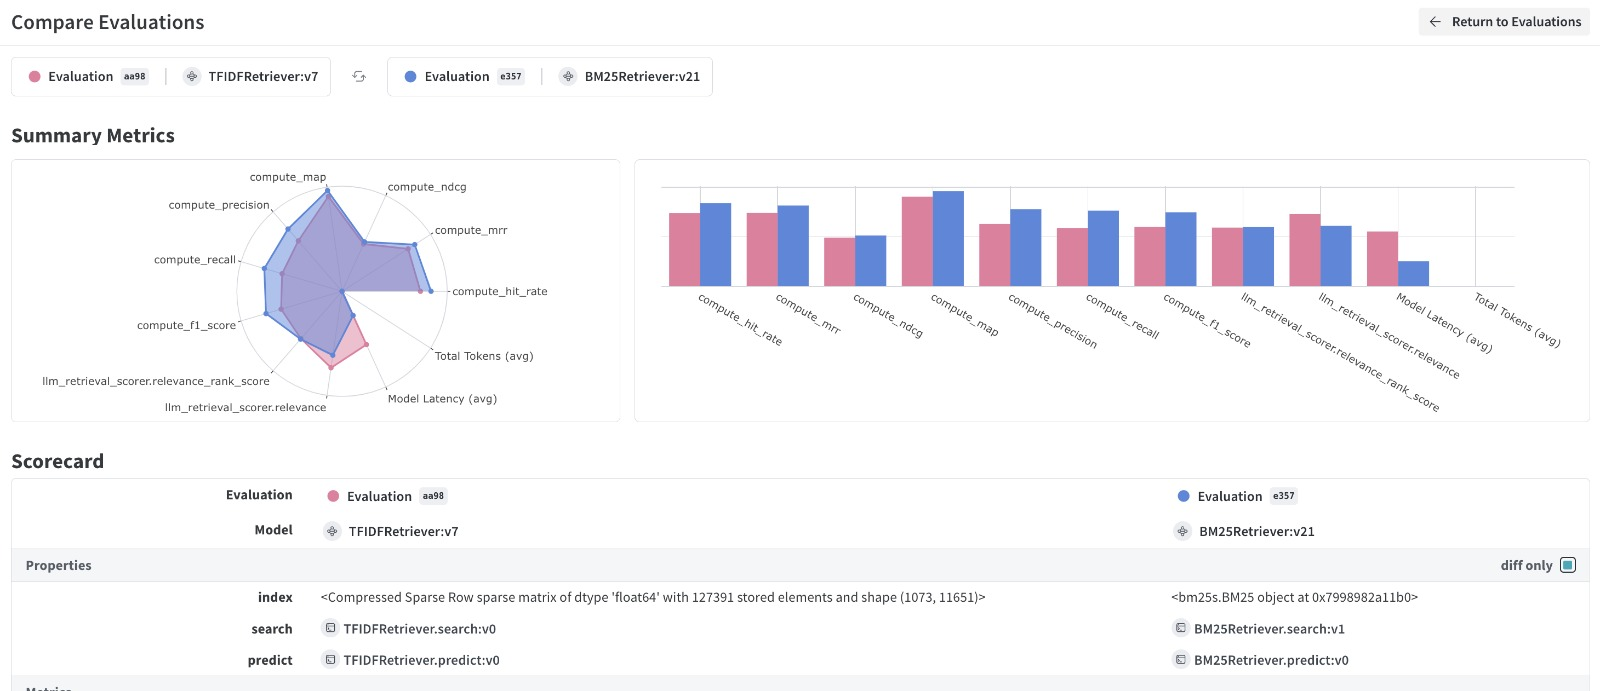


BM25 outperforms TFIDF in most relevance metrics:

1. Higher MAP, NDCG, and MRR indicate better ranking and relevance.
2. Improved precision and recall suggest a better balance in retrieving relevant documents.
3. Slightly better hit rate.

TFIDF advantages:

* Significantly lower latency, beneficial for time-sensitive applications.

Trade-offs:

* BM25 offers superior retrieval performance at the cost of higher latency.
* TFIDF is faster but generally less accurate in retrieval.


In [25]:
response_evaluations = weave.Evaluation(
    name="Response_Evaluation",
    dataset=eval_dataset,
    scorers=RESPONSE_METRICS,
    preprocess_model_input=lambda x: {"query": x["question"]},
)
bm25_response_scores = asyncio.run(response_evaluations.evaluate(bm25_rag_pipeline))
tfidf_response_scores = asyncio.run(response_evaluations.evaluate(tfidf_rag_pipeline))

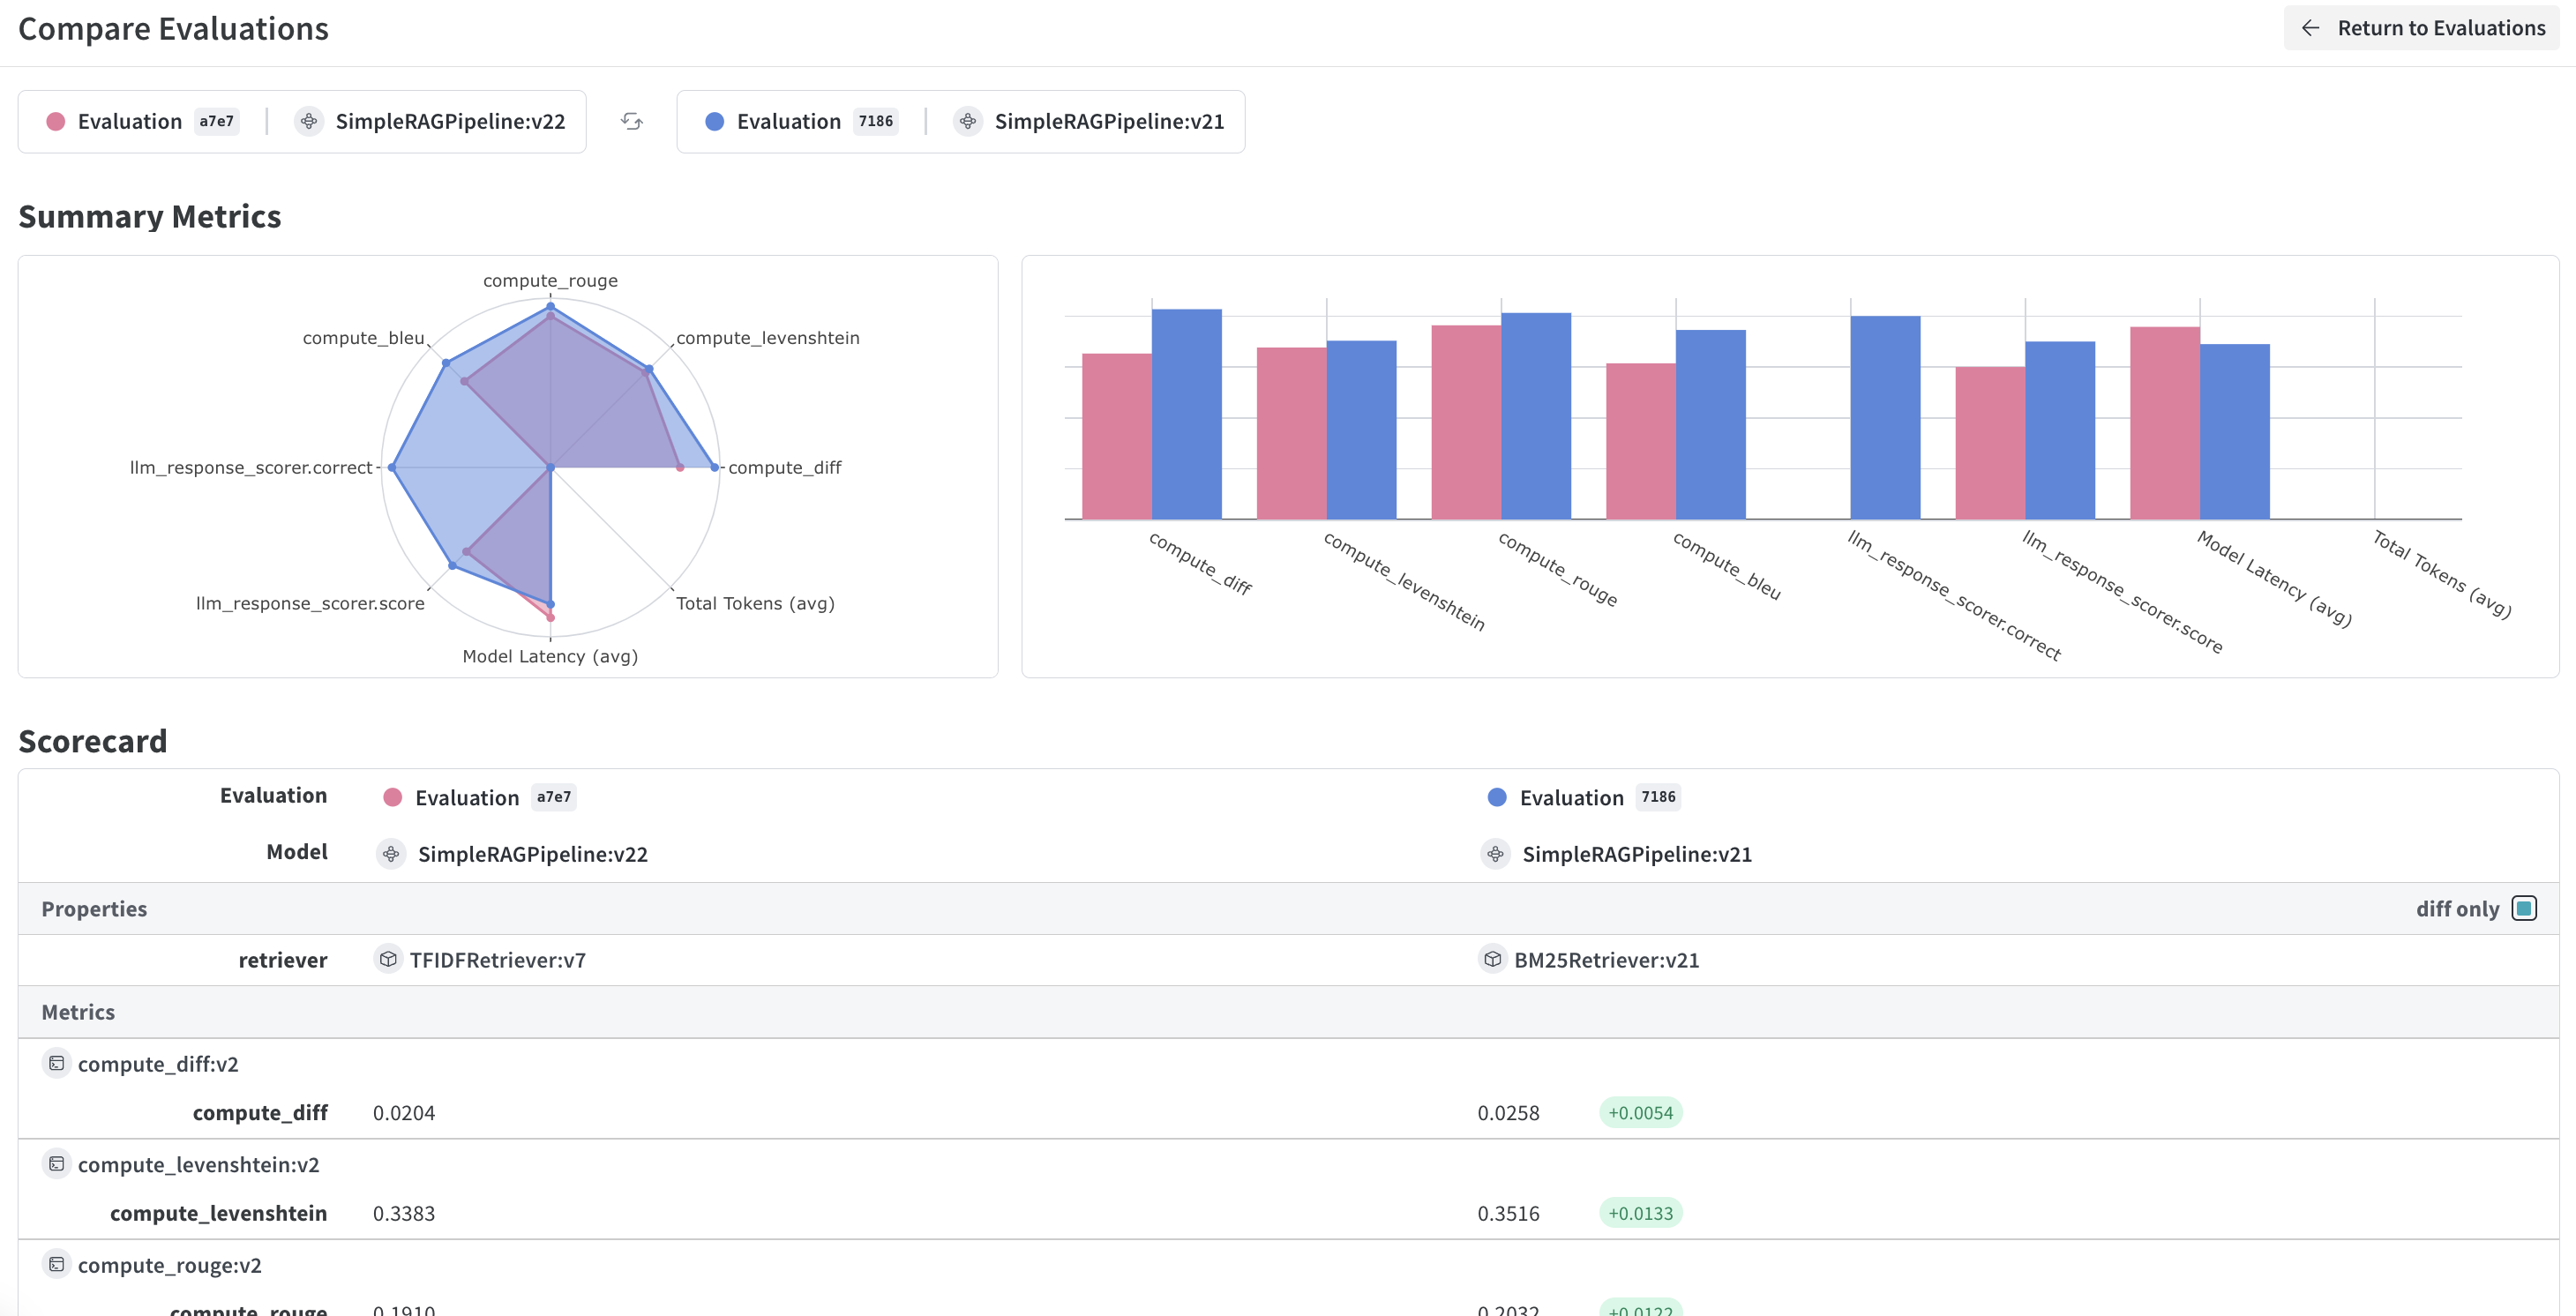



Again BM25 retriever outperforms TFIDF across most response metrics (ROUGE, BLEU, Correctness, Response Score), leading to more relevant and accurate responses.

* Slightly better ROUGE and BLEU scores indicate more overlap with reference responses.
* Higher LLM Response Scorer results suggest more accurate and coherent responses.
* Marginally higher Levenshtein and diff scores show slight differences from reference responses.

TFIDF advantages:

* Lower latency, making it more efficient for quicker response generation.

Trade-offs:

* BM25 offers superior response quality at the cost of higher latency.
* TFIDF is faster but generally produces less accurate results.

Choose based on your priority: response quality (BM25) or speed (TFIDF).

## **Key Takeaways**

1. **Data Quality is Crucial:** The effectiveness of a RAG system heavily depends on the quality of data ingestion and preprocessing. "Garbage in, garbage out" applies to LLMs as well.

2. **Accurate Tokenization:** Using the correct tokenization strategy is essential for proper text processing and context management. The actual token count often differs significantly from simple word counts.

3. **Preprocessing Importance:** Cleaning raw data by removing markdown elements, special characters, and extra whitespace is crucial for optimizing LLM input and improving retrieval accuracy.

4. **Semantic Chunking:** This advanced chunking strategy groups similar sentences, preserving context and improving retrieval relevance compared to simpler methods like fixed-length splitting.

5. **Retrieval Method Comparison:** Exploring alternative retrieval methods, such as BM25 vs. TF-IDF, can lead to significant improvements in RAG system performance.

6. **Evaluation is Key:** Regularly evaluating both retrieval and response metrics is crucial for understanding the impact of changes and optimizing the RAG pipeline.

7. **Experimentation:** The optimal approach for data preprocessing, chunking, and retrieval often depends on the specific use case. Experimentation is encouraged to find the best configuration for your RAG system.

8. **Scalability and Updates:** When building a data ingestion pipeline, consider scalability and the ability to handle periodic updates as data sources change.